In [8]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
from cartopy import crs as ccrs, feature as cfeature
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import re
import xarray as xr
from matplotlib.colors import to_hex
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import contextily as cx
import geodatasets
import rasterio
from rasterio.transform import from_origin
import matplotlib.colors as mcolors


from scripts.geodata import *

#  Suppress warnings issued by Cartopy when downloading data files
warnings.filterwarnings('ignore')

# reload modules
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
month_abbr_hydr = {
    'sep': 1,
    'oct': 2,
    'nov': 3,
    'dec': 4,
    'jan': 5,
    'feb': 6,
    'mar': 7,
    'apr': 8,
    'may': 9,
    'jun': 10,
    'jul': 11,
    'aug': 12,
}

## Transform to rasters for QGIS:

In [10]:
glacierName = 'rhone'
year = 2020

filename_nc = f"{glacierName}_{year}.nc"
path_nc_lv95 = f"results/nc/{glacierName}/lv95/"
path_nc_wgs84 = f"results/nc/{glacierName}/wgs84/"

filename_tif = f"{glacierName}_{year}.tif"
path_tif_wgs84 = f"results/tif/{glacierName}/wgs84/"
path_tif_lv95 = f"results/tif/{glacierName}/lv95/"

createPath(path_tif_lv95)
createPath(path_tif_wgs84)

In [11]:
gdf, gdf_class, raster_data, extent = TransformToRaster(
    filename_nc, filename_tif, path_nc_wgs84, path_tif_wgs84, path_tif_lv95)

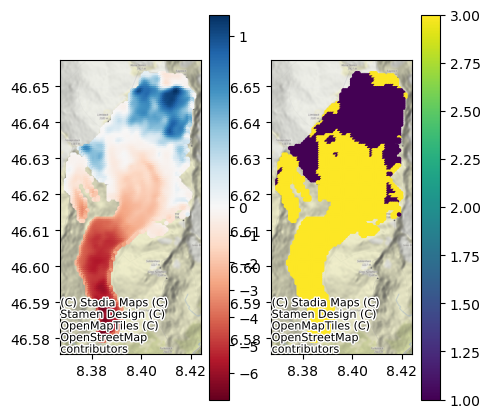

In [12]:
API_KEY = "000378bd-b0f0-46e2-a46d-f2165b0c6c02"
provider = cx.providers.Stadia.StamenTerrain(api_key=API_KEY)
provider["url"] = provider["url"] + f"?api_key={API_KEY}"

vmin, vmax = gdf.data.min(), gdf.data.max()
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
fig, axs = plt.subplots(1, 2, figsize=(5, 5))
gdf_clean = gdf.dropna(subset=["data"])
gdf_clean.plot(
    column="data",  # Column to visualize
    cmap="RdBu",  # Color map suitable for glacier data
    norm=norm,
    legend=True,  # Display a legend
    ax=axs[0],
    markersize=5,  # Adjust size if points are too small or large
    missing_kwds={"color": "lightgrey"}  # Define color for NaN values
)
cx.add_basemap(axs[0], crs=gdf.crs, source=provider)

gdf_clean = gdf_class.dropna(subset=["data"])
gdf_clean.plot(
    column="data",  # Column to visualize
    legend=True,  # Display a legend
    ax=axs[1],
    markersize=5,  # Adjust size if points are too small or large
    missing_kwds={"color": "lightgrey"}  # Define color for NaN values
)
cx.add_basemap(axs[1], crs=gdf.crs, source=provider)

In [13]:
vmin, vmax = gdf.data.min(), gdf.data.max()

# Calculate the relative position of 0
relative_position = (0 - vmin) / (vmax - vmin) * 100

# Print the result
print(f"The relative position of 0 is {relative_position:.2f}%")

The relative position of 0 is 86.10%


### All months:

In [15]:
for month in month_abbr_hydr:
    monthNb = month_abbr_hydr[month]

    filename_nc = f"{glacierName}_{year}_{monthNb}.nc"
    path_nc_lv95 = f"results/nc/{glacierName}/lv95/"
    path_nc_wgs84 = f"results/nc/{glacierName}/wgs84/"

    filename_tif = f"{glacierName}_{year}_{monthNb}.tif"
    path_tif_wgs84 = f"results/tif/{glacierName}/wgs84/"
    path_tif_lv95 = f"results/tif/{glacierName}/lv95/"  # normally EPSG Code: 2056

    gdf, gdf_class, raster_data, extent = TransformToRaster(
        filename_nc, filename_tif, path_nc_wgs84, path_tif_wgs84,
        path_tif_lv95)

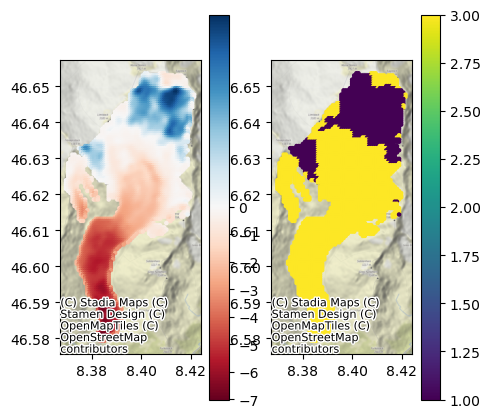

In [16]:
API_KEY = "000378bd-b0f0-46e2-a46d-f2165b0c6c02"
provider = cx.providers.Stadia.StamenTerrain(api_key=API_KEY)
provider["url"] = provider["url"] + f"?api_key={API_KEY}"

vmin, vmax = gdf.data.min(), gdf.data.max()
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
fig, axs = plt.subplots(1, 2, figsize=(5, 5))
gdf_clean = gdf.dropna(subset=["data"])
gdf_clean.plot(
    column="data",  # Column to visualize
    cmap="RdBu",  # Color map suitable for glacier data
    norm=norm,
    legend=True,  # Display a legend
    ax=axs[0],
    markersize=5,  # Adjust size if points are too small or large
    missing_kwds={"color": "lightgrey"}  # Define color for NaN values
)
cx.add_basemap(axs[0], crs=gdf.crs, source=provider)

gdf_clean = gdf_class.dropna(subset=["data"])
gdf_clean.plot(
    column="data",  # Column to visualize
    legend=True,  # Display a legend
    ax=axs[1],
    markersize=5,  # Adjust size if points are too small or large
    missing_kwds={"color": "lightgrey"}  # Define color for NaN values
)
cx.add_basemap(axs[1], crs=gdf.crs, source=provider)

## Step by step example of one file:

### Step 1: Open the NetCDF file


In [ ]:
ds_xy = xr.open_dataset(path_nc_lv95 + filename_nc)
ds_latlon = xr.open_dataset(path_nc_wgs84 + filename_nc)

# Smoothing
ds_xy_g = GaussianFilter(ds_xy)
ds_latlon_g = GaussianFilter(ds_latlon)

# Show effet of Smoothing:
vmin, vmax = np.min([
    ds_xy.pred_masked.min().values,
    ds_xy_g.pred_masked.min()
]), np.max([ds_xy.pred_masked.max().values,
            ds_xy_g.pred_masked.max()])
max_abs_value = max(abs(vmin), abs(vmax))
norm = mcolors.TwoSlopeNorm(vmin=-max_abs_value, vcenter=0, vmax=max_abs_value)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
ds_xy.pred_masked.plot.imshow(cmap='RdBu', norm=norm, ax=axs[0])
axs[0].set_title('Original')

# Plot or analyze `smoothed_data` as needed
ds_xy_g.pred_masked.plot.imshow(cmap='RdBu', norm=norm, ax=axs[1])
axs[1].set_title('Gaussian Filter')

# print min and max values
print(ds_xy.pred_masked.min().values, ds_xy.pred_masked.max().values)
print(ds_xy_g.pred_masked.min().values, ds_xy_g.pred_masked.max().values)

### Step 2: transform to geopandas

In [ ]:
gdf, lon, lat = toGeoPandas(ds_latlon_g)

# Reproject to LV95 (EPSG:2056) swiss coordinates
# gdf_lv95 = gdf.to_crs("EPSG:2056")

API_KEY = "000378bd-b0f0-46e2-a46d-f2165b0c6c02"
provider = cx.providers.Stadia.StamenTerrain(api_key=API_KEY)
provider["url"] = provider["url"] + f"?api_key={API_KEY}"

fig, ax = plt.subplots(figsize=(5, 5))
gdf_clean = gdf.dropna(subset=["data"])
gdf_clean.plot(
    column="data",  # Column to visualize
    cmap="Reds",  # Color map suitable for glacier data
    legend=True,  # Display a legend
    ax=ax,
    markersize=5,  # Adjust size if points are too small or large
    missing_kwds={"color": "lightgrey"}  # Define color for NaN values
)
cx.add_basemap(ax, crs=gdf.crs, source=provider)

### Step 3: transform to raster

In [ ]:
# Transform to raster from geopandas
raster_data, extent = toRaster(gdf,
                               lon,
                               lat,
                               file_name=path_tif_wgs84 + filename_tif)

# reproject raster to Swiss coordinates (LV95)
reproject_raster_to_lv95(path_tif_wgs84 + filename_tif,
                         path_tif_lv95 + filename_tif)

### Opt step 4: for clariden
Need to merge two rasters

In [ ]:
if 'clariden' in glacierName:
    merge_rasters('results/tif/claridenL_2022_w_lv95.tif',
                  'results/tif/claridenU_2022_w_lv95.tif',
                  'results/tif/clariden_2022_w_lv95.tif')